In [ ]:
# Goal:  - construct the Markowitz Curve with top 6 stocks in SPY and 1 risk-free asset e.g. bonds 
#        - study the curve   
# will be using QuantConnect

In [ ]:
# 1) obtain historical prices - Daily, 3 months worth - because I want the data to reflect heavily on the last 3 months

# 2) obtain stock expected return, variance & std, covariance

# 3) construct the portfolio using the stocks and assigning weights (w1, w2,...,w7)

# 4) monte carlo of (w1, w2,...,w7) and construct the Markowitz curve

# 5) plot the optimal portfolio weights (corresponding to the highest MC simulated Sharpe Ratio)
# 5a) develop a function in which a user-input std (sigma), outputs the portfolio weights that correspond to the optimal MC simulated E[R] (along the efficient frontier)
# 5b) plot individual stocks risk-return

# 6) include risk free asset in the portfolio - study the markowitz plot

# 7) simplify code to make it easier for application

# bonus) study how correlations affect the look of the chart

In [ ]:
#all the needed modules
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#dataset by MorningStar
# https://www.quantconnect.com/datasets/morning-star-us-fundamentals
#  FineFundamental Attributes > click all the blue links to get what you need


qb = QuantBook() #open an instance of the QuantBook

#fill out this list with equity symbols to be added to be researched
equitySymbolList = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'GOOGL'] 


added_equity = []
for mySec in equitySymbolList:
    added_equity.append( qb.AddEquity(mySec, dataNormalizationMode=DataNormalizationMode.Adjusted) ) #adds each equity into the research environment

# data normalization
# https://www.quantconnect.com/docs/v2/research-environment/datasets/us-equity

In [ ]:
# df.isnull().values.any() - checks for NaN in the dataframAe

In [ ]:

# 1) obtain historical prices - Daily, 3 months worth - because I want the data to reflect heavily on the last 3 months

# Request some historical data

df = pd.DataFrame()
for equity in added_equity: 
    # reformats data
    equity_df = qb.History(equity.Symbol, timedelta(days=365/4), Resolution.Daily)['close'].reset_index()  
    equity_df = equity_df.drop('symbol', axis=1)
    equity_df = equity_df.set_index('time')
    equity_df = equity_df.rename(columns={'close': equity.Symbol.Value })

    df = pd.concat([df,equity_df], axis=1) # output dataframe has timeseries as index and column names as ticker symbols


returns_df = df.pct_change(1).dropna() # outputs returns df

log_returns_df = np.log(1 + returns_df) # ln(1+r) form

In [ ]:
# 2) obtain stock expected return, variance & std, covariance

In [ ]:
X = log_returns_df.describe().loc['std'] * 100
Y = log_returns_with_RF_df.describe().loc['mean'] * 100

# Create a scatter plot of 'x' vs. 'y'
plt.scatter(X, Y)

# Add labels to specific points
for symbol in pd.concat([X, Y],axis=1).index:
    plt.annotate(f'{symbol}', xy=(X.loc[symbol], Y.loc[symbol]))

plt.xlabel('sigma - std daily %')
plt.ylabel('E[R] - expected return daily %')
plt.title('Mean-Variance Plot - Daily')
plt.show()

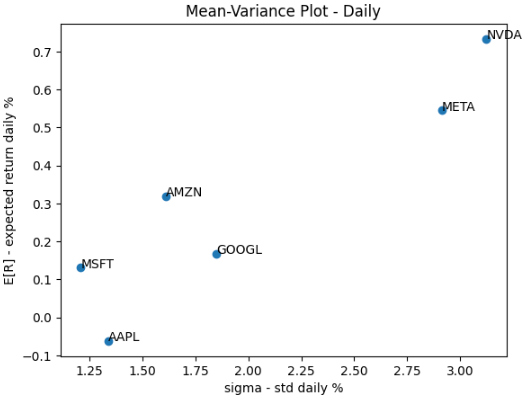

In [ ]:
log_returns_df.cov() # variance-covariance matrix for daily

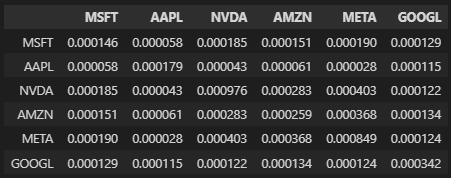

In [ ]:
log_returns_df.corr() # correlation matrix for daily

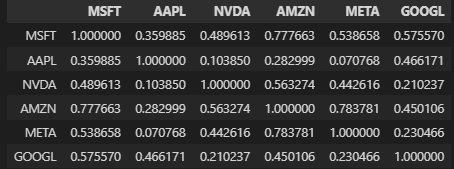

In [ ]:
X = log_returns_df.describe().loc['std'] * 100 * (252/4)**(0.5) # 'annualized' but to only 3 months, note: 252 trading days in a year
Y = log_returns_df.describe().loc['mean'] * 100 * ( 252/4 ) # 'annualized' but to only 3 months

# Create a scatter plot of 'x' vs. 'y'
plt.scatter(X, Y)

# Add labels to specific points
for symbol in pd.concat([X, Y],axis=1).index:
    plt.annotate(f'{symbol}', xy=(X.loc[symbol], Y.loc[symbol]))

plt.xlabel('sigma - std 3-months %')
plt.ylabel('E[R] - expected return 3-months %')
plt.title('Mean-Variance Plot - 3-months')
plt.show()

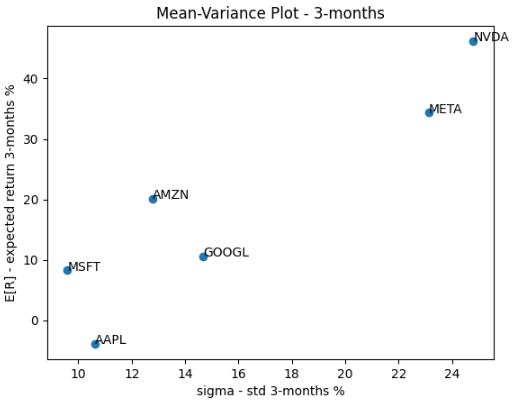

In [ ]:
# IMPORTANT NOTE: you can "annualize" or "3-month-ize" mean, variance, covariance i.e. mu*(252/4), sigma_squared*(252/4)

log_returns_df.cov()*(252/4) # for 3-months, Var(R)_daily * (252/4) and Cov(R1, R2)_daily * (252/4)

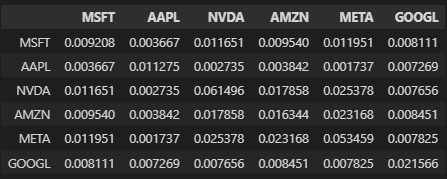

In [ ]:
( log_returns_df*(252/4) ).cov() # this is wrong, does not make sense to multiply 252/4 factor to each daily returns 

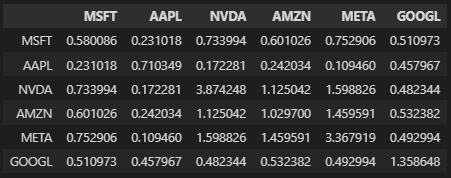

In [ ]:
# 3) construct the portfolio using the stocks and assigning weights (w1, w2,...,w7)

In [ ]:
#define a function that generates weights given N number of stocks in a portfolio
def gen_weights(N):  
    weights = np.random.random(N)
    return weights/np.sum(weights)

# NOTE: w1 + w2 + ... + wn = 1.00

In [ ]:
np.random.seed(0)
weights_arr = gen_weights(len(returns_df.columns))
weights_arr

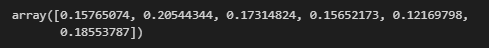

In [ ]:
# define R_p = w1*R1 + ... + wn*Rn, where each Ri is a random variable and wi is deterministic
# calculates portfolio expected return E[R_p] = E[w*R] = w1*E[R1] + w2*E[R2] + ...+ wn*E[Rn]
# inputs: log returns df, weights array
# outputs: E[R_p] = scalar, annualization is not applied here
def portfolio_exp_return(log_returns_df, weights_arr):
    return ( log_returns_df.mean() * weights_arr ).sum()


In [ ]:
portfolio_exp_return(log_returns_df, weights_arr) # daily expected return

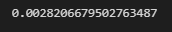

In [ ]:
portfolio_exp_return(log_returns_df, weights_arr) * (252/4) # 3-month-ized expected return

In [ ]:
# calculates portfolio variance: Var(w1*R1 + w2*R2 +...+ wn*Rn) = transpose(W)*CovMatrix(R1+R2+R3+...+Rn)*W 
# inputs: log returns df, weights array
# output: std[R_p] is scalar, , annualization is not applied here

def portfolio_std(log_returns_df, weights_arr):
    var_p = np.dot(weights_arr.transpose(), np.dot(log_returns_df.cov(), weights_arr))
    return np.sqrt(var_p) 


In [ ]:
portfolio_std(log_returns_df, weights_arr) # daily stadard dev

In [ ]:
portfolio_std(log_returns_df, weights_arr) * (252/4)**(1/2) #  3-month-ized stadard dev

In [ ]:
# 4) monte carlo of (w1, w2,...,w7) and construct the Markowitz curve (E[R] vs std)


# 5) plot the optimal portfolio weights (corresponding to the highest MC simulated Sharpe Ratio)
# 5a) develop a function in which a user-input std (sigma), outputs the portfolio weights that correspond to the optimal MC simulated E[R] (along the efficient frontier)
# 5b) plot individual stocks risk-return


In [ ]:
# Monte Carlo for a portfolio WITHOUT risk-free asset

mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []


for sim in range(3000):
    weights_arr = gen_weights(len(log_returns_df.columns)) # generate a randomized weight vector 
    mc_weights.append(weights_arr) # append to the weights list list

    sim_returns = portfolio_exp_return(log_returns_df, weights_arr) * (252/4) # generate consolidated portfolio returns given the portfolio weight and returns data
    mc_portfolio_returns.append(sim_returns) #append to the portfolio returns list
    
    sim_vol = portfolio_std(log_returns_df, weights_arr) * (252/4)**(1/2) # calculate portfolio volatility
    mc_portfolio_vol.append(sim_vol) #append to the portfolio volatility list

# calculate sharpe_ratios vectorially
risk_free_rate = 0.0
mc_sharpe_ratios = (np.array(mc_portfolio_returns) - risk_free_rate) / np.array(mc_portfolio_vol) #assume benchmark = 0% risk free rate

# outputs the weights of the portfolio that has the highest sharp ratio from the monte carlo
weights_highest_SR = mc_weights[np.argmax(mc_sharpe_ratios)] 
weights_highest_SR

# prints the corresponding weights from the MC sim with the highest SR
MC_SR_optimal_weights_df = pd.DataFrame(index=log_returns_df.columns, columns=['Highest SR Weights'], data=weights_highest_SR)
print(MC_SR_optimal_weights_df)
print('')


#############
# develop a function in which a user-input std (sigma), outputs the portfolio weights that correspond to the optimal MC simulated E[R] (along the efficient frontier)
c = 0.10 # user input std (sigma)
epsilon = 0.001 # must be set as the next decimal place in order to get the dot at the efficient frontier

mc_portfolio_vol_df = pd.DataFrame(data=mc_portfolio_vol)

# will create a very small interval with sigma is in the interval i.e. |sigma - c| < epsilon OR c-epsilon < sigma < c+epsilon
# simultaneously, I will need to obtain the indices of the small sample that was grabbed from the original list
sample_df = mc_portfolio_vol_df[0][ (mc_portfolio_vol_df[0] > (c - epsilon)) & (mc_portfolio_vol_df[0] < (c + epsilon)) ]

# obtain the index of the highest return in the sample
mc_portfolio_returns_df = pd.DataFrame(data=mc_portfolio_returns)
user_index = mc_portfolio_returns_df.iloc[sample_df.index].idxmax()[0] # obtain the highest return given the sample index


MC_user_weights_df = pd.DataFrame(index=log_returns_df.columns, columns=[f'User STD={c} Weights'], data=mc_weights[user_index] )
print(MC_user_weights_df)




# plotting markowitz graph
plt.figure(dpi=200,figsize=(10,5))

plt.plot( mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)], 'ro'  ) # plots the sigma-mu pair that corresponds to the highest SR
plt.annotate(f'Highest SR', xy=(mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)]))

plt.plot( mc_portfolio_vol[user_index], mc_portfolio_returns[user_index], 'ro'  ) # plots the optimal sigma-mu given user input std (sigma)
plt.annotate(f'User', xy=(mc_portfolio_vol[user_index], mc_portfolio_returns[user_index]))


plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='SHARPE RATIO - 3-months')
plt.xlabel('VOLATILITY - 3-months')
plt.ylabel('RETURNS - 3-months')

#################
# plotting the individual stocks risk-return
X = log_returns_df.describe().loc['std'] * (252/4)**(0.5) # 'annualized' but to only 3 months, note: 252 trading days in a year
Y = log_returns_df.describe().loc['mean'] * ( 252/4 ) # 'annualized' but to only 3 months

# Create a scatter plot of 'x' vs. 'y'
plt.scatter(X, Y)

# Add labels to specific points
for symbol in pd.concat([X, Y],axis=1).index:
    plt.annotate(f'{symbol}', xy=(X.loc[symbol], Y.loc[symbol]))
#################

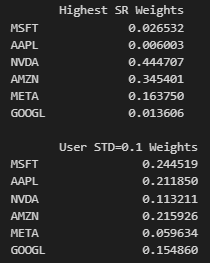

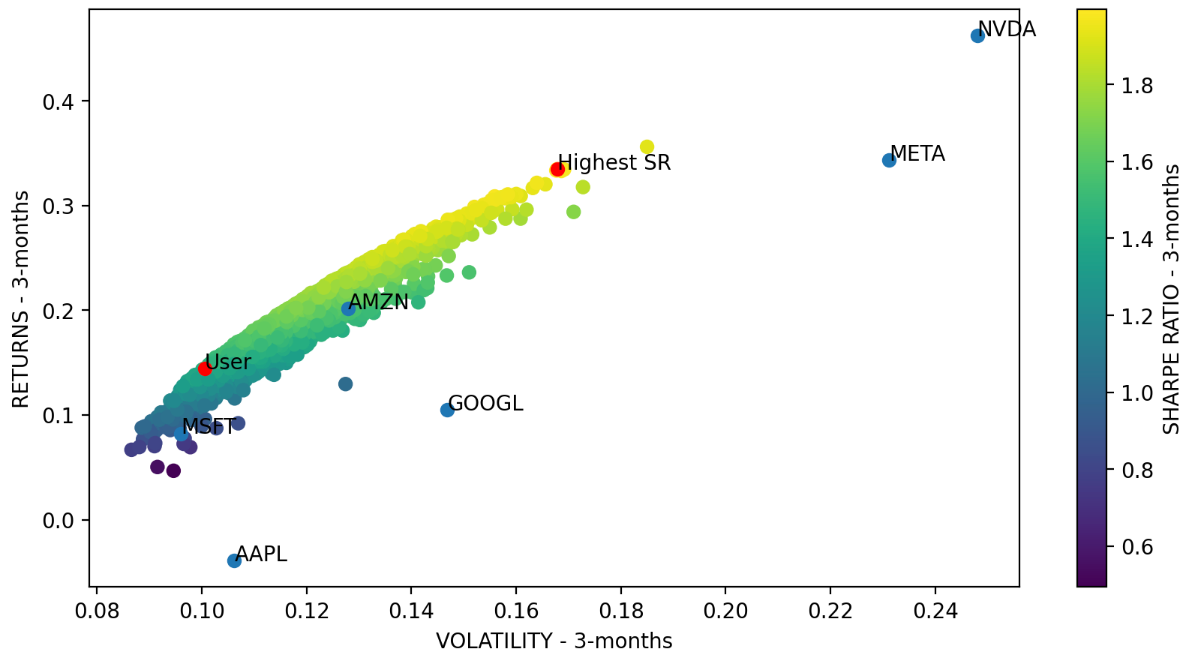

In [ ]:
# CODE BELOW IS TO PLOT THE EFFICIENT FRONTIER for the portfolio without Risk-free asset
# must run MC for the portfolio without Risk-free asset

# minimize - takes in a function and a bunch of constraints and outputs value(s) that will minimize the input function

def function_to_minimize(weights_arr):
    #minimize -1*SR is equivalent to maximizing +SR (which we want)
    # look up the concept of Gradient Descent
      #  https://www.youtube.com/watch?v=Gbz8RljxIHo
        # I speculate that by putting that (-) in our SR formula, the minimize function internally takes the 1st derivative...
        #  ...and does the iteration calculations in which the negative (-) of our defined function gets carried on and...
        # ... actually forces the iteration calculation to increase/maximize rather than minimize
    
    return -1 * ( portfolio_exp_return(log_returns_df, weights_arr) * (252/4) / portfolio_std(log_returns_df, weights_arr) * (252/4)**(1/2) )



#bound 1: each weight is bounded from 0 to 1 i.e. the tuples:
# ((0,1),(0,1),(0,1),(0,1))

bounds = tuple((0,1) for n in range( len(log_returns_df.columns) ) )
bounds


#bound 2: the sum of each weight should equal to one

#will need to understand this
#however, in the minimization algorithm, we have to define the constraint being 'zero'
sum_constraint = ( {'type':'eq','fun':lambda weights_arr: np.sum(weights_arr)-1} ) #dictionary tuple
                                                                            #recall that the sum of weights should be equal to 1.00


#starting guess or initial condition
N = len(log_returns_df.columns)
equal_weights = N * [1/N] #scalar multiplying to a list
equal_weights


from scipy.optimize import minimize

minimize(fun=function_to_minimize, 
         x0=equal_weights,
        bounds=bounds,
        constraints=sum_constraint)


#75 Efficient Frontier

#range returns that I want (based from Markov's bullet graph) from 0.18 to 0.28
expected_returns_range = np.linspace(0.0, 0.40, 100)
expected_returns_range


#the second constraints says that the calculated returns should equal the expected_returns_range
# this is done by subtracting the two and obtain zero
constraints = ({'type':'eq', 'fun':lambda weights_arr: np.sum(weights_arr)-1} , 
               {'type':'eq','fun':lambda weights_arr: portfolio_exp_return(log_returns_df, weights_arr)* (252/4) - possible_return})


# modified the portfolio_std to bring the "annualization" to be internal to the function
# removed log_returns_df as input in order for the next block of code to work

def mod_portfolio_std(weights_arr):
    var_p = np.dot(weights_arr.transpose(), np.dot(log_returns_df.cov() * (252/4) , weights_arr))
    return np.sqrt(var_p) 



#expected_returns_range are your y-poinys
# volatility are your x points

frontier_vol = []
portfolio_holdings = []


for possible_return in expected_returns_range: #possible_return is chosen within the array of expected_returns_range
    result = minimize(mod_portfolio_std ,equal_weights, bounds=bounds,constraints=constraints) #same inputs as in the last lecture but the bounds was modified to have boundaries on a range of returns
    print(result)
    #'result' is a scipy optimize class
    #volatility for the return
    frontier_vol.append(result['fun']) #for each iteration, the minimize function outputs the attribute 'fun' which represents the minimized volatility
                                        # for a corresponding returns in the expected_returns_range
    portfolio_holdings.append(result['x']) # x = weights for the corresponding returns and volatility in the iteration



# plotting markowitz graph
plt.figure(dpi=200,figsize=(10,5))

plt.plot( mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)], 'ro'  ) # plots the sigma-mu pair that corresponds to the highest SR
plt.annotate(f'Highest SR', xy=(mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)]))

plt.plot( mc_portfolio_vol[user_index], mc_portfolio_returns[user_index], 'ro'  ) # plots the optimal sigma-mu given user input std (sigma)
plt.annotate(f'User', xy=(mc_portfolio_vol[user_index], mc_portfolio_returns[user_index]))


plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='SHARPE RATIO - 3-months')
plt.xlabel('VOLATILITY - 3-months')
plt.ylabel('RETURNS - 3-months')

#################
# plotting the individual stocks risk-return
X = log_returns_df.describe().loc['std'] * (252/4)**(0.5) # 'annualized' but to only 3 months, note: 252 trading days in a year
Y = log_returns_df.describe().loc['mean'] * ( 252/4 ) # 'annualized' but to only 3 months

# Create a scatter plot of 'x' vs. 'y'
plt.scatter(X, Y)

# Add labels to specific points
for symbol in pd.concat([X, Y],axis=1).index:
    plt.annotate(f'{symbol}', xy=(X.loc[symbol], Y.loc[symbol]))
#################

plt.plot(frontier_vol,expected_returns_range,color='red',ls='--',lw=3)
    

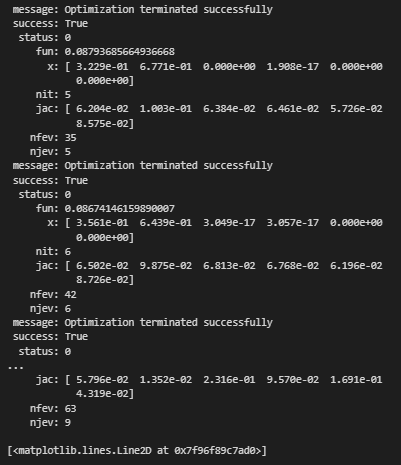

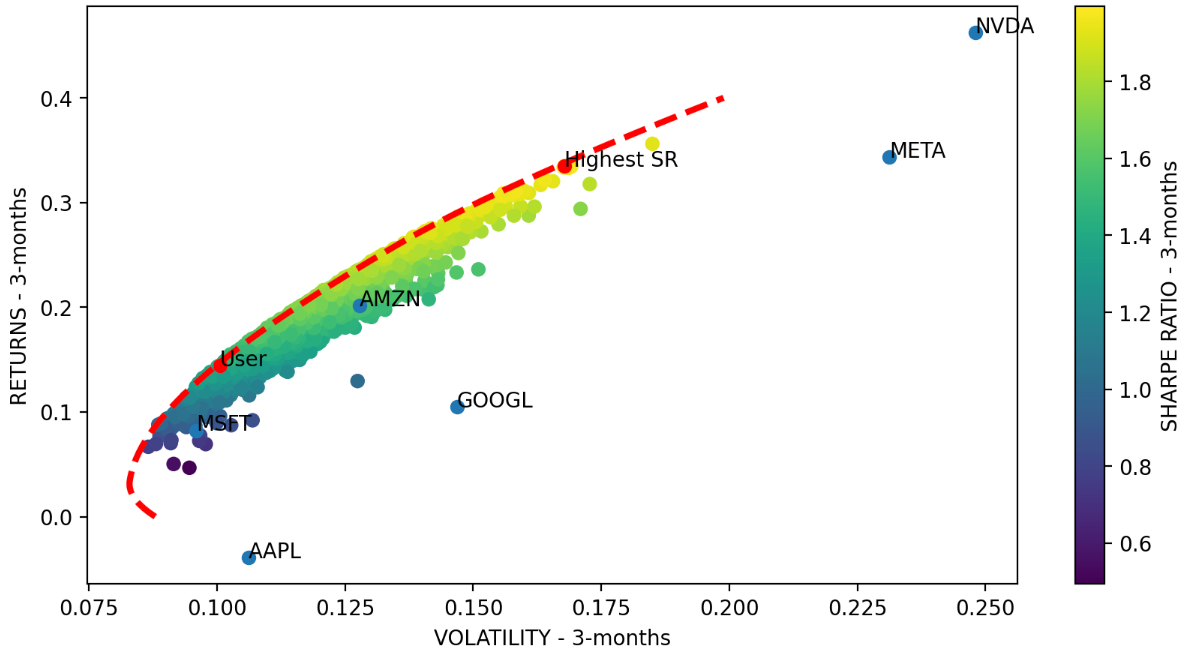

In [ ]:
# 6) include risk free asset in the portfolio
# assume risk-free rate (annual) Rf = 5.0% 
# Rf_daily = 5.0% / 252

riskfree_df = pd.DataFrame(data=[0.05/252 for x in returns_df.index], index=returns_df.index, columns=['RiskFree'])
riskfree_df

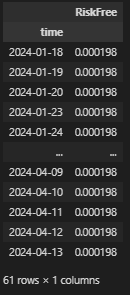

In [ ]:
returns_with_RF_df = pd.concat( [returns_df, riskfree_df],axis=1)

log_returns_with_RF_df = np.log(1 + returns_with_RF_df) # ln(1+r) form

log_returns_with_RF_df

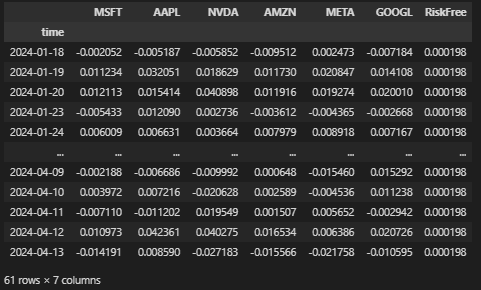

In [ ]:
log_returns_with_RF_df.cov()

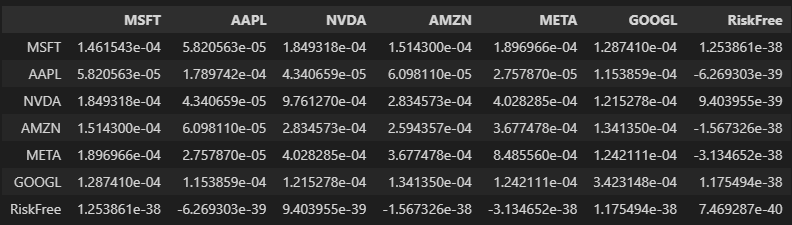

In [ ]:
log_returns_with_RF_df.describe()

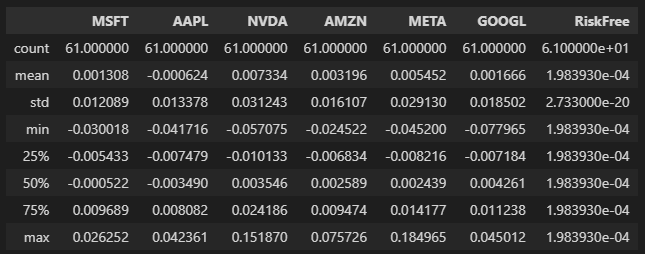

In [ ]:
log_returns_with_RF_df.mean() * 252/4

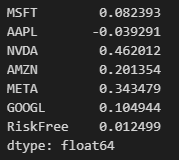

In [ ]:
# Monte Carlo of a portfolio WITH a risk-free asset
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []


for sim in range(3000):
    weights_arr = gen_weights(len(log_returns_with_RF_df.columns)) # generate a randomized weight vector 
    mc_weights.append(weights_arr) # append to the weights list list

    sim_returns = portfolio_exp_return(log_returns_with_RF_df, weights_arr) * (252/4) # generate consolidated portfolio returns given the portfolio weight and returns data
    mc_portfolio_returns.append(sim_returns) #append to the portfolio returns list
    
    sim_vol = portfolio_std(log_returns_with_RF_df, weights_arr) * (252/4)**(1/2) # calculate portfolio volatility
    mc_portfolio_vol.append(sim_vol) #append to the portfolio volatility list

# calculate sharpe_ratios vectorially
risk_free_rate = 0.0
mc_sharpe_ratios = (np.array(mc_portfolio_returns) - risk_free_rate) / np.array(mc_portfolio_vol) #assume benchmark = 0% risk free rate

# outputs the weights of the portfolio that has the highest sharp ratio from the monte carlo
weights_highest_SR = mc_weights[np.argmax(mc_sharpe_ratios)] 
weights_highest_SR

# prints the corresponding weights from the MC sim with the highest SR
MC_SR_optimal_weights_df = pd.DataFrame(index=log_returns_with_RF_df.columns, columns=['Highest SR Weights'], data=weights_highest_SR)
print(MC_SR_optimal_weights_df)
print('')


#############
# develop a function in which a user-input std (sigma), outputs the portfolio weights that correspond to the optimal MC simulated E[R] (along the efficient frontier)
c = 0.10 # user input std (sigma)
epsilon = 0.001 # must be set as the next decimal place in order to get the dot at the efficient frontier

mc_portfolio_vol_df = pd.DataFrame(data=mc_portfolio_vol)

# will create a very small interval with sigma is in the interval i.e. |sigma - c| < epsilon OR c-epsilon < sigma < c+epsilon
# simultaneously, I will need to obtain the indices of the small sample that was grabbed from the original list
sample_df = mc_portfolio_vol_df[0][ (mc_portfolio_vol_df[0] > (c - epsilon)) & (mc_portfolio_vol_df[0] < (c + epsilon)) ]

# obtain the index of the highest return in the sample
mc_portfolio_returns_df = pd.DataFrame(data=mc_portfolio_returns)
user_index = mc_portfolio_returns_df.iloc[sample_df.index].idxmax()[0] # obtain the highest return given the sample index


MC_user_weights_df = pd.DataFrame(index=log_returns_with_RF_df.columns, columns=[f'User STD={c} Weights'], data=mc_weights[user_index] )
print(MC_user_weights_df)




# plotting markowitz graph
plt.figure(dpi=200,figsize=(10,5))

plt.plot( mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)], 'ro'  ) # plots the sigma-mu pair that corresponds to the highest SR
plt.annotate(f'Highest SR', xy=(mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)]))

plt.plot( mc_portfolio_vol[user_index], mc_portfolio_returns[user_index], 'ro'  ) # plots the optimal sigma-mu given user input std (sigma)
plt.annotate(f'User', xy=(mc_portfolio_vol[user_index], mc_portfolio_returns[user_index]))


plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='SHARPE RATIO - 3-months')
plt.xlabel('VOLATILITY - 3-months')
plt.ylabel('RETURNS - 3-months')

#################
# plotting the individual stocks risk-return
X = log_returns_with_RF_df.describe().loc['std'] * (252/4)**(0.5) # 'annualized' but to only 3 months, note: 252 trading days in a year
Y = log_returns_with_RF_df.describe().loc['mean'] * ( 252/4 ) # 'annualized' but to only 3 months

# Create a scatter plot of 'x' vs. 'y'
plt.scatter(X, Y)

# Add labels to specific points
for symbol in pd.concat([X, Y],axis=1).index:
    plt.annotate(f'{symbol}', xy=(X.loc[symbol], Y.loc[symbol]))
#################

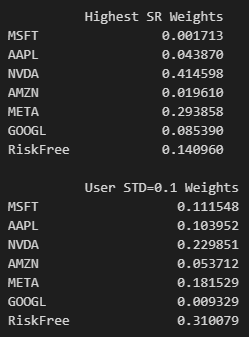

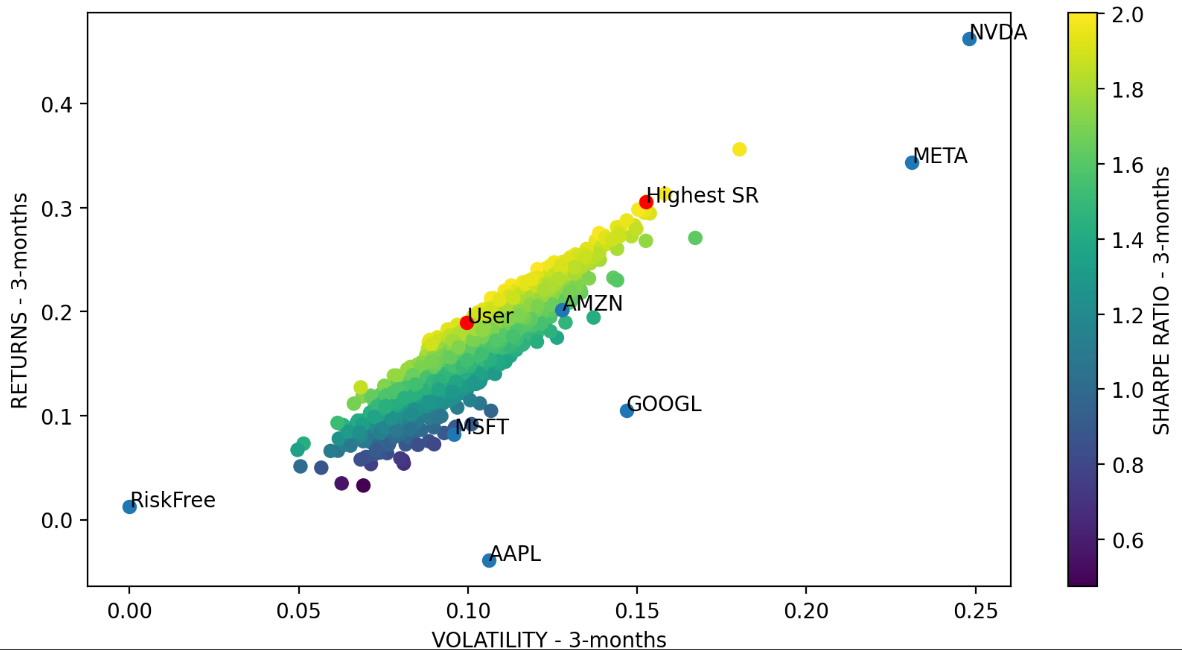

In [ ]:
# CODE BELOW IS TO PLOT THE EFFICIENT FRONTIER for the portfolio WITH Risk-free asset
# must run MC for the portfolio WITH Risk-free asset

# minimize - takes in a function and a bunch of constraints and outputs value(s) that will minimize the input function

def function_to_minimize(weights_arr):
    #minimize -1*SR is equivalent to maximizing +SR (which we want)
    # look up the concept of Gradient Descent
      #  https://www.youtube.com/watch?v=Gbz8RljxIHo
        # I speculate that by putting that (-) in our SR formula, the minimize function internally takes the 1st derivative...
        #  ...and does the iteration calculations in which the negative (-) of our defined function gets carried on and...
        # ... actually forces the iteration calculation to increase/maximize rather than minimize
    
    return -1 * ( portfolio_exp_return(log_returns_with_RF_df, weights_arr) * (252/4) / portfolio_std(log_returns_with_RF_df, weights_arr) * (252/4)**(1/2) )



#bound 1: each weight is bounded from 0 to 1 i.e. the tuples:
# ((0,1),(0,1),(0,1),(0,1))

bounds = tuple((0,1) for n in range( len(log_returns_with_RF_df.columns) ) )
bounds


#bound 2: the sum of each weight should equal to one

#will need to understand this
#however, in the minimization algorithm, we have to define the constraint being 'zero'
sum_constraint = ( {'type':'eq','fun':lambda weights_arr: np.sum(weights_arr)-1} ) #dictionary tuple
                                                                            #recall that the sum of weights should be equal to 1.00


#starting guess or initial condition
N = len(log_returns_with_RF_df.columns)
equal_weights = N * [1/N] #scalar multiplying to a list
equal_weights


from scipy.optimize import minimize

minimize(fun=function_to_minimize, 
         x0=equal_weights,
        bounds=bounds,
        constraints=sum_constraint)


#75 Efficient Frontier

#range returns that I want (based from Markov's bullet graph) from 0.18 to 0.28
expected_returns_range = np.linspace(0.0, 0.40, 100)
expected_returns_range


#the second constraints says that the calculated returns should equal the expected_returns_range
# this is done by subtracting the two and obtain zero
constraints = ({'type':'eq', 'fun':lambda weights_arr: np.sum(weights_arr)-1} , 
               {'type':'eq','fun':lambda weights_arr: portfolio_exp_return(log_returns_with_RF_df, weights_arr)* (252/4) - possible_return})


# modified the portfolio_std to bring the "annualization" to be internal to the function
# removed log_returns_with_RF_df as input in order for the next block of code to work

def mod_portfolio_std(weights_arr):
    var_p = np.dot(weights_arr.transpose(), np.dot(log_returns_with_RF_df.cov() * (252/4) , weights_arr))
    return np.sqrt(var_p) 



#expected_returns_range are your y-poinys
# volatility are your x points

frontier_vol = []
portfolio_holdings = []


for possible_return in expected_returns_range: #possible_return is chosen within the array of expected_returns_range
    result = minimize(mod_portfolio_std ,equal_weights, bounds=bounds,constraints=constraints) #same inputs as in the last lecture but the bounds was modified to have boundaries on a range of returns
    print(result)
    #'result' is a scipy optimize class
    #volatility for the return
    frontier_vol.append(result['fun']) #for each iteration, the minimize function outputs the attribute 'fun' which represents the minimized volatility
                                        # for a corresponding returns in the expected_returns_range
    portfolio_holdings.append(result['x']) # x = weights for the corresponding returns and volatility in the iteration



# plotting markowitz graph
plt.figure(dpi=200,figsize=(10,5))

plt.plot( mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)], 'ro'  ) # plots the sigma-mu pair that corresponds to the highest SR
plt.annotate(f'Highest SR', xy=(mc_portfolio_vol[np.argmax(mc_sharpe_ratios)], mc_portfolio_returns[np.argmax(mc_sharpe_ratios)]))

plt.plot( mc_portfolio_vol[user_index], mc_portfolio_returns[user_index], 'ro'  ) # plots the optimal sigma-mu given user input std (sigma)
plt.annotate(f'User', xy=(mc_portfolio_vol[user_index], mc_portfolio_returns[user_index]))


plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='SHARPE RATIO - 3-months')
plt.xlabel('VOLATILITY - 3-months')
plt.ylabel('RETURNS - 3-months')

#################
# plotting the individual stocks risk-return
X = log_returns_with_RF_df.describe().loc['std'] * (252/4)**(0.5) # 'annualized' but to only 3 months, note: 252 trading days in a year
Y = log_returns_with_RF_df.describe().loc['mean'] * ( 252/4 ) # 'annualized' but to only 3 months

# Create a scatter plot of 'x' vs. 'y'
plt.scatter(X, Y)

# Add labels to specific points
for symbol in pd.concat([X, Y],axis=1).index:
    plt.annotate(f'{symbol}', xy=(X.loc[symbol], Y.loc[symbol]))
#################

plt.plot(frontier_vol,expected_returns_range,color='red',ls='--',lw=3)
    

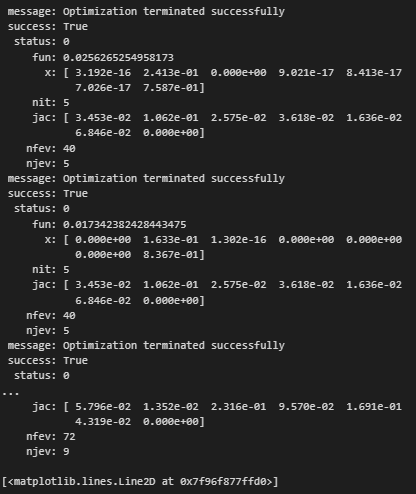

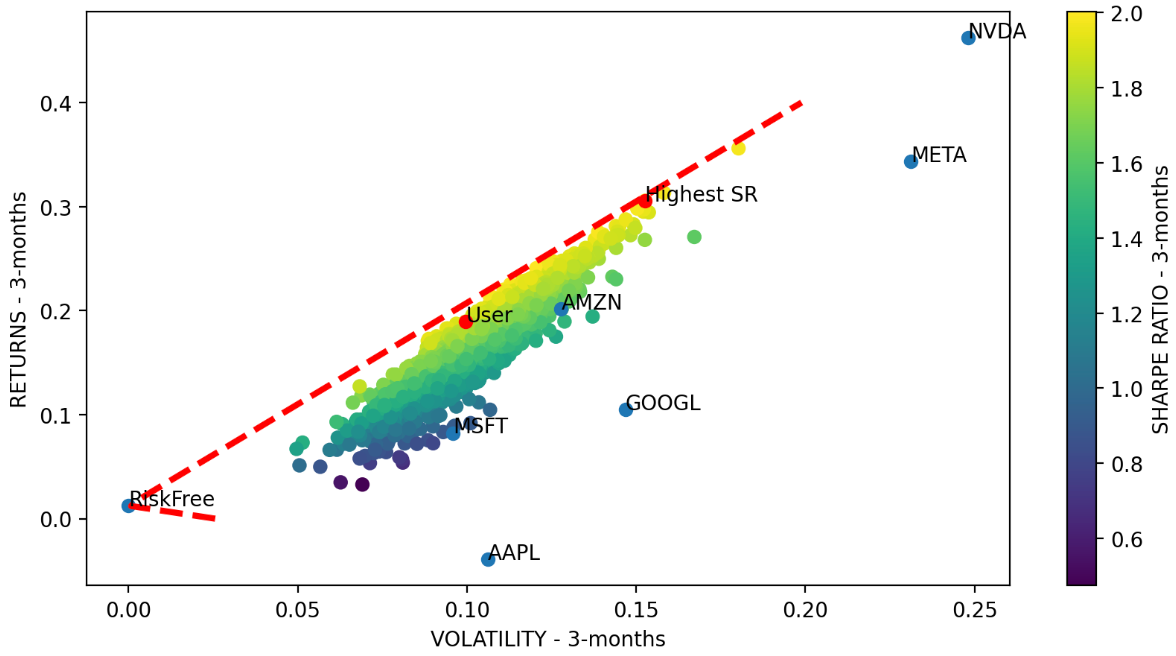